# Pepper Watering Fuzzy Control System

This notebook uses the learned functions of the tutorial `01_FuzzyControlSystem.ipynb`. I tried to experiment a bit with different MF functions and also plot the defuzzified plots.

**Input variable:**
- **Temperature** (0=cold, 40=hot), modeled using trapezoidal membership functions:
  `cold`, `moderate`, `hot`

**Output variable:**
- **Water amount** (0=low, 10=high in liters), modeled using triangular membership functions:
  `low`, `medium`, `high`

**Fuzzy rules:**
1. If temperature is cold, then water amount is low.
2. If temperature is moderate, then water amount is medium.
3. If temperature is hot, then water amount is high.

The system computes the recommended water amount for a given temperature using centroid
defuzzification. Membership degrees for each output fuzzy set are printed, and the dominant
set is identified. Membership functions and the resulting fuzzy output are visualized with
matplotlib.



Fuzzy memberships for water: {'low': np.float64(0.0), 'medium': np.float64(0.0), 'high': np.float64(0.531)}

Dominant membership label for watering: high

Recommended water amount: 7.7L (high)

Fuzzy memberships for temp: {'cold': np.float64(0.0), 'moderate': np.float64(0.222), 'hot': np.float64(1.0)}

Dominant membership label for teno: hot








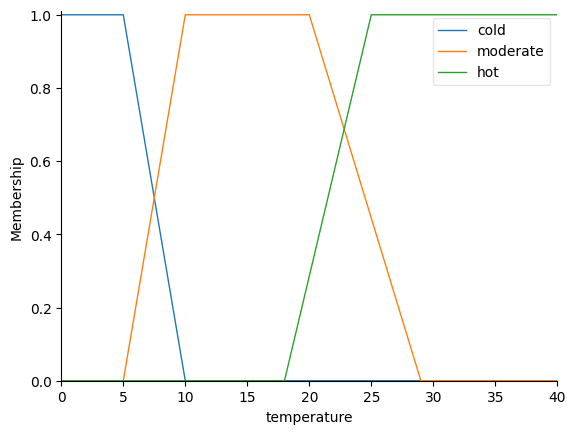

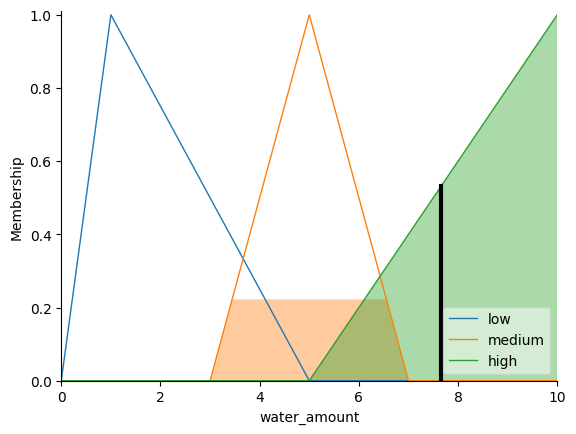

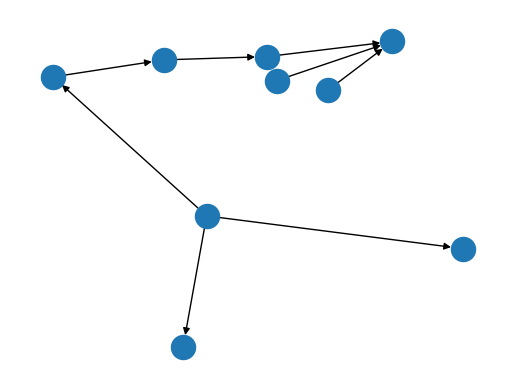

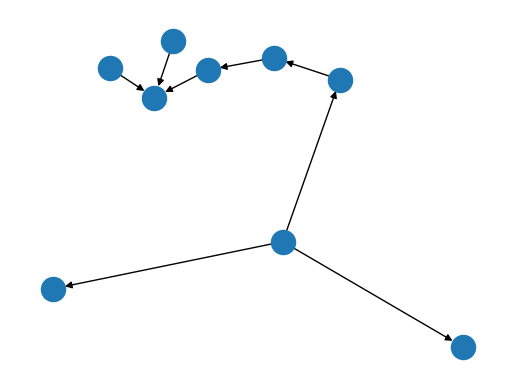

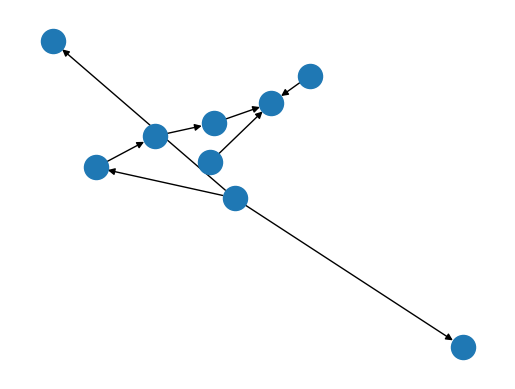

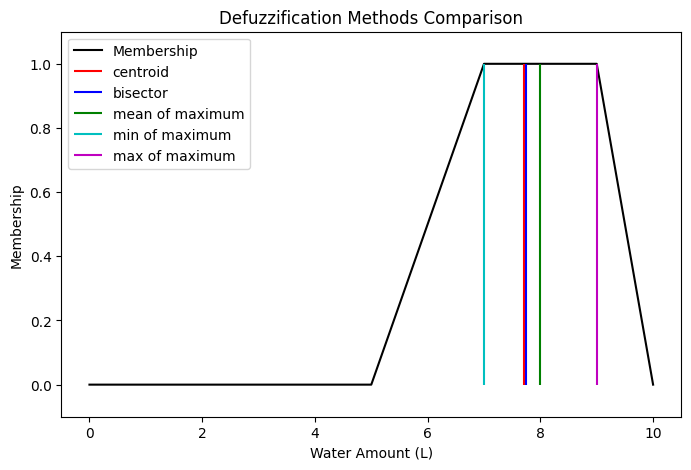

In [34]:
%matplotlib inline
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
%matplotlib inline

#temperature (0=cold, 40=hot) try to simulate degs here
temperature = ctrl.Antecedent(np.arange(0, 41, 1), 'temperature')
#water amount (0=low, 10=high) in L
water_amount = ctrl.Consequent(np.arange(0, 11, 1), 'water_amount')

# def membership functions try out trapmf for temp
temperature['cold'] = fuzz.trapmf(temperature.universe, [0, 0, 5, 10])
temperature['moderate'] = fuzz.trapmf(temperature.universe, [5, 10, 20, 29])
temperature['hot'] = fuzz.trapmf(temperature.universe, [18, 25, 40, 40])
# use trimf for water amount
water_amount['low'] = fuzz.trimf(water_amount.universe, [0, 1, 5])
water_amount['medium'] = fuzz.trimf(water_amount.universe, [3, 5, 7])
water_amount['high'] = fuzz.trimf(water_amount.universe, [5, 10, 10])

# rules
rule1 = ctrl.Rule(temperature['cold'], water_amount['low'])
rule2 = ctrl.Rule(temperature['moderate'], water_amount['medium'])
rule3 = ctrl.Rule(temperature['hot'], water_amount['high'])


watering_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
watering_sim = ctrl.ControlSystemSimulation(watering_ctrl)

# set temp
temp_value = 27
watering_sim.input['temperature'] = temp_value
watering_sim.compute()

crisp_output = watering_sim.output['water_amount']

# get ms deg for each set
x = water_amount.universe
degrees = {
    label: fuzz.interp_membership(x, mf.mf, crisp_output)
    for label, mf in water_amount.terms.items()
}

x_temp = temperature.universe
degrees_temp = {
    label: fuzz.interp_membership(x_temp, mf.mf, temp_value)
    for label, mf in temperature.terms.items()
}
# get most dominant membership
dominant_label = max(degrees, key=degrees.get)
dominant_temp_label = max(degrees_temp, key=degrees_temp.get)

print("Fuzzy memberships for water:", {k: round(v, 3) for k, v in degrees.items()})
print()
print("Dominant membership label for watering:", dominant_label)
print()
print(f"Recommended water amount: {crisp_output:.1f}L ({dominant_label})")
print()
print("Fuzzy memberships for temp:", {k: round(v, 3) for k, v in degrees_temp.items()})
print()
print("Dominant membership label for teno:", dominant_temp_label)
print()
print()

# plot membership funcs
temperature.view()
print()
water_amount.view(sim=watering_sim)
print()
rule1.view()
print()
rule2.view()
print()
rule3.view()

# Defuzzification comparison for water amount
x = water_amount.universe
mfx = fuzz.trapmf(x, [5, 7, 9, 10])

# Compute defuzzification values
defuzz_centroid = fuzz.defuzz(x, mfx, 'centroid')
defuzz_bisector = fuzz.defuzz(x, mfx, 'bisector')
defuzz_mom = fuzz.defuzz(x, mfx, 'mom')
defuzz_som = fuzz.defuzz(x, mfx, 'som')
defuzz_lom = fuzz.defuzz(x, mfx, 'lom')

labels = ['centroid', 'bisector', 'mean of maximum', 'min of maximum', 'max of maximum']
xvals = [defuzz_centroid, defuzz_bisector, defuzz_mom, defuzz_som, defuzz_lom]
colors = ['r', 'b', 'g', 'c', 'm']
ymax = [fuzz.interp_membership(x, mfx, i) for i in xvals]

plt.figure(figsize=(8,5))
plt.plot(x, mfx, 'k', label='Membership')
for xv, y, label, color in zip(xvals, ymax, labels, colors):
    plt.vlines(xv, 0, y, color=color, label=label)
plt.xlabel('Water Amount (L)')
plt.ylabel('Membership')
plt.title('Defuzzification Methods Comparison')
plt.ylim(-0.1, 1.1)
plt.legend(loc=2)
plt.show()